In [339]:
%load_ext autoreload
%autoreload 2
from IPython.display import YouTubeVideo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MNIST database of handwritten digits
### (Modified National Institute of Standards and Technology database)

https://en.wikipedia.org/wiki/MNIST_database

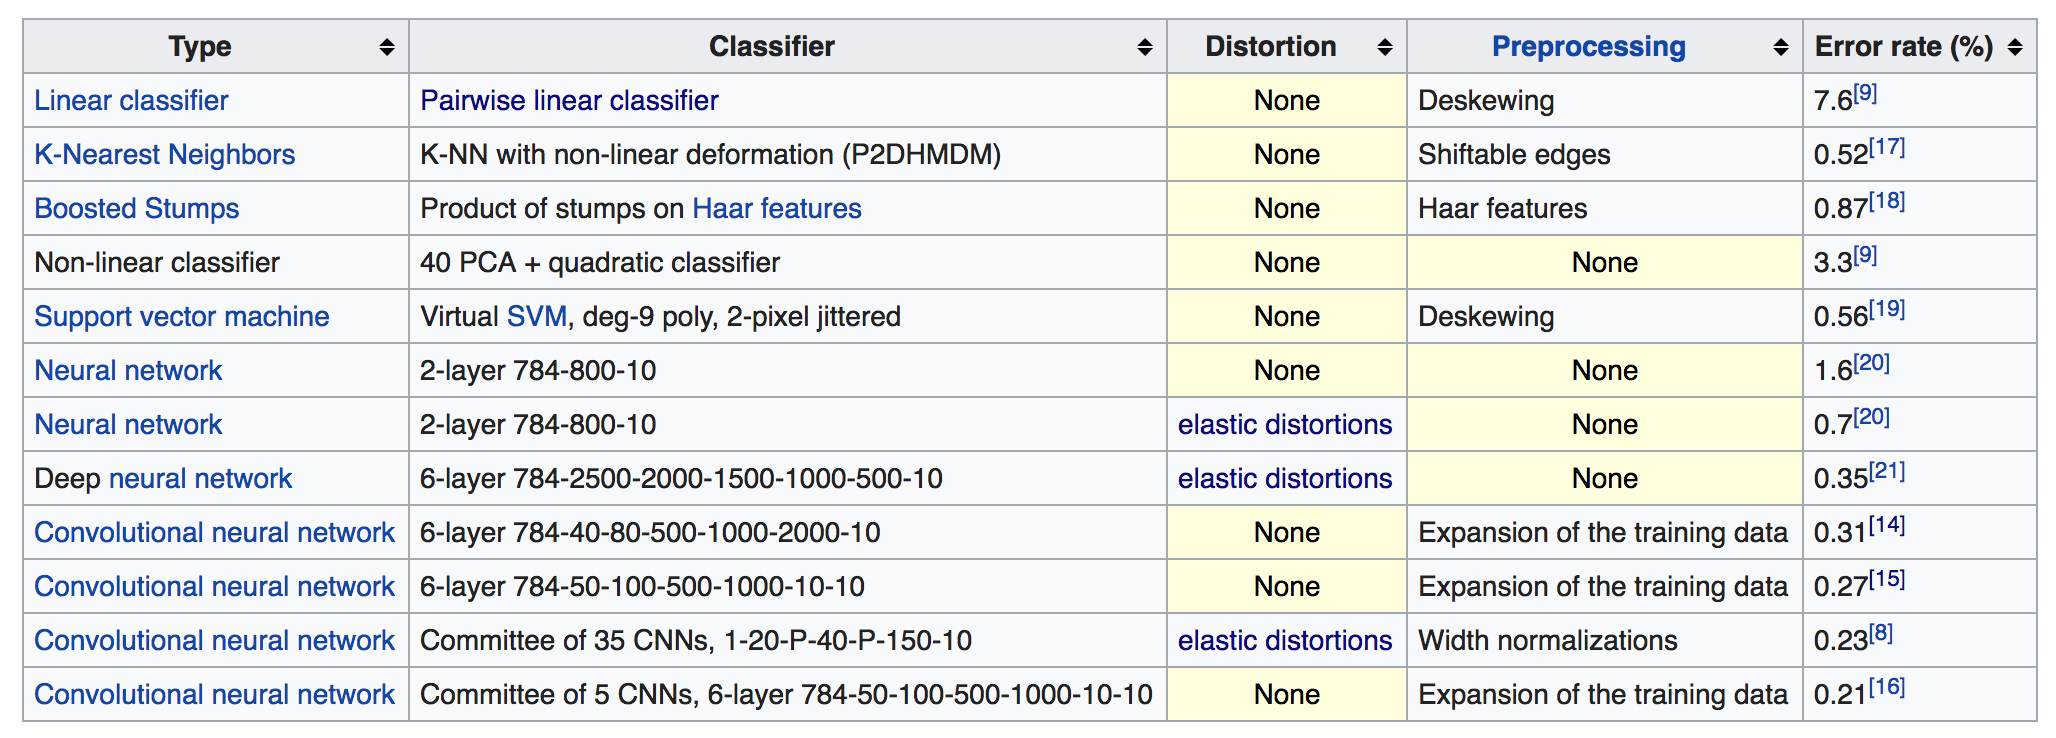

- Mas de 20 años de publicaciones al respecto
- Muy investigado y mucha documentación

Video recomendado:

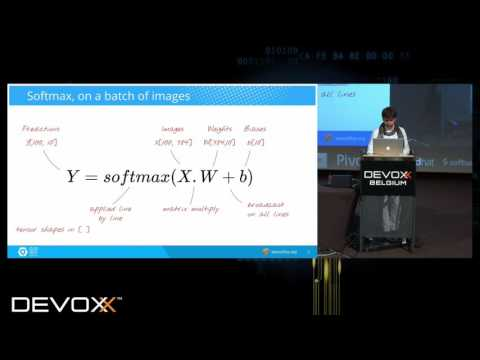

In [340]:
YouTubeVideo('vq2nnJ4g6N0')

In [341]:
import keras
import numpy as np
from matplotlib import pyplot as plt
from fnn_helper import PlotLosses
from MNIST_helper import plot_numbers, visualize_input
import draw_nn

## Importo el dataset

In [343]:
from keras.datasets import mnist
(x, y), (x_test, y_test) = mnist.load_data()

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x.shape[0]*(1-validation))
# Training Set
x_train = x[:N_validation_split]
y_train = y[:N_validation_split]

# Cross Validation Set
x_val = x[N_validation_split:]
y_val = y[N_validation_split:]

In [345]:
print('Training set data:', x_train.shape)
print('Training labels:', y_train.shape)
print()
print('CV set data:', x_val.shape)
print('CV labels:', y_val.shape)
print()
print('Testing set data:',x_test.shape)
print('Testing labels:', y_test.shape)

Training set data: (48000, 28, 28)
Training labels: (48000,)

CV set data: (12000, 28, 28)
CV labels: (12000,)

Testing set data: (10000, 28, 28)
Testing labels: (10000,)


## Grafico los primeros dígitos

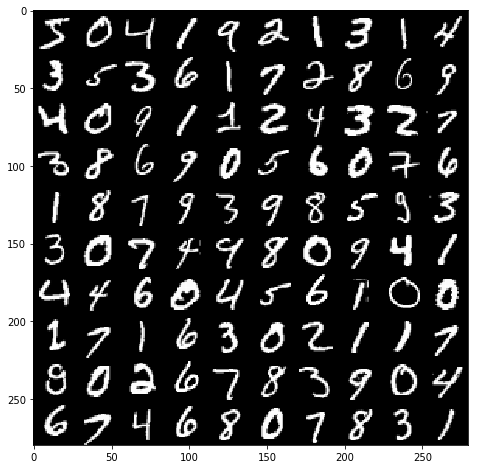

In [346]:
plot_numbers(x_train,range(100), columns=10, figsize=(8, 8))

## Vizualizo un dígito

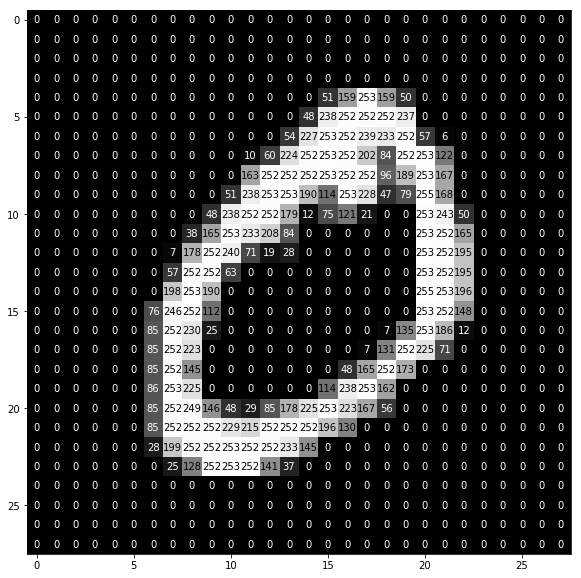

In [347]:
fig = plt.figure(figsize = (10,10)) 
ax = fig.add_subplot(111)
visualize_input(x_train[1], ax)
plt.show()

# Regresión logística multinomial

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_mldata

In [78]:
x_train_flattened = x_train.reshape(-1,784)
x_test_flattened = x_test.reshape(-1,784)

In [9]:
clf_logistic = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=10, tol=0.05)
clf_logistic.fit(x_train_flattened, y_train)
train_score_logistic = clf_logistic.score(x_train_flattened, y_train)
test_score_logistic = clf_logistic.score(x_test_flattened, y_test)
print(train_score_logistic, test_score_logistic)

0.929333333333 0.9256


# Red lo más simple posible

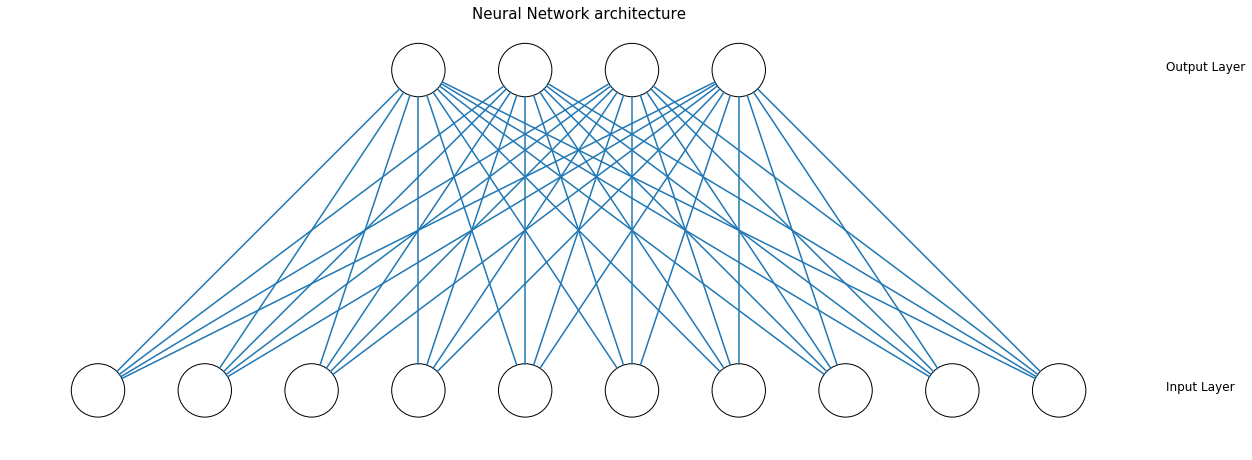

Realmente tengo 784 neuronas en la entrada y 10 en la salida


In [10]:
network = draw_nn.DrawNN( [10,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada y 10 en la salida")

In [348]:
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras.utils import np_utils

[Keras](https://keras.io/)
- API de alto nivel (high-level neural networks API)
- Escrita en Python 
- **Backend**: Corre TensorFlow, CNTK, or Theano

In [12]:
x_train.shape[1:]

(28, 28)

## Acomodo Salida: one-hot encoding

In [350]:
y_train_categorical = keras.utils.to_categorical(y_train)
y_val_categorical = keras.utils.to_categorical(y_val)
y_test_categorical = keras.utils.to_categorical(y_test)
print(y_train_categorical.shape)
print(y_train_categorical[0])

(48000, 10)
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


# Armamos el modelo

In [351]:
output_size = 10
def single_layer(lr=0.00000001):
    # Creo el modelo
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(output_size, kernel_initializer='zeros', name='Entrada'))
    model.add(Activation('softmax'))
    
    # Compilo el modelo
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model

model_single_layer = single_layer()
model_single_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_73 (Flatten)         (None, 784)               0         
_________________________________________________________________
Entrada (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_41 (Activation)   (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


- ¿Por que tiene esa cantidad de parametros?

Capas ([Core Layers](https://keras.io/layers/core/)):
- Dense
- Flatten
- Activation

Parámetros:
- Learning Rate (lr)
- Funciones de activación ([Activations](https://keras.io/activations/)): Sigmoid, Relu, [softmax](https://en.wikipedia.org/wiki/Softmax_function)
- Optimizers: [Keras](https://keras.io/optimizers/), [Articulo interesante](http://ruder.io/optimizing-gradient-descent/)
- Costo ([losses](https://keras.io/losses/))
- [Initializers](https://keras.io/initializers/)

## Exactitud del modelo sin entrenar
**¿Cuanto es de esperar?**

In [81]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.30258536301
accuracy:  0.098


## Compilamos el modelo
lr suele ser proporcional al mini-bath size. Es decir que si funciona con un lr y aumento el bs, deberia aumentar proporcionalmente el lr

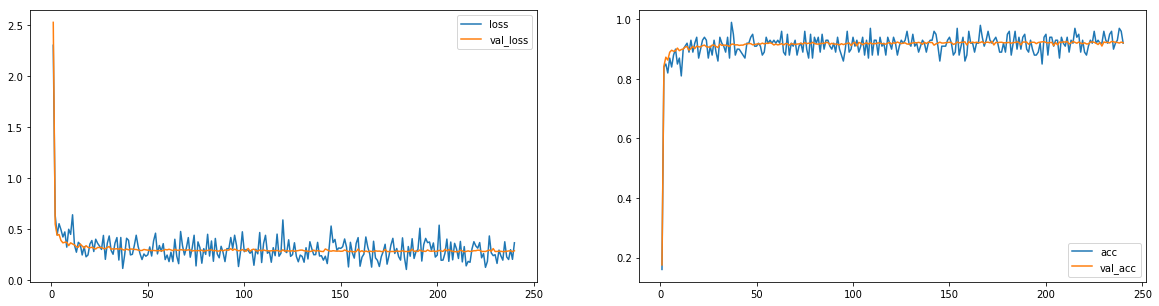

Epoch 00009: val_loss did not improve
48000/48000 [==============================] - 13s - loss: 0.2774 - acc: 0.9229 - val_loss: 0.2930 - val_acc: 0.9208


In [352]:
# Callbacks
## Callback para graficar
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=20, x_val=x_val, y_val_categorical=y_val_categorical)
## Callback para guardar pesos
checkpointer = ModelCheckpoint(filepath='single-layer.mnist.hdf5', verbose=1, save_best_only=True)

model_single_layer = single_layer(lr=0.00001) #lr=0.01, 0.001, 0.00001, 0.000001, 0.00000001
model_single_layer.fit(x_train, 
                       y_train_categorical,
                       epochs=10, batch_size=100, 
                       verbose=1, 
                       validation_data = (x_val, y_val_categorical),
                       callbacks=[plot_losses, checkpointer],
                      )

**¿Por que val_loss y val_acc es menos ruidosa que loss y val?**

# Despues de entrenar el modelo

In [353]:
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.295103374085
accuracy:  0.92


# Analisis de los pesos

In [354]:
weights = model_single_layer.get_weights()[0]
biases = model_single_layer.get_weights()[1]
print(weights.shape)
print(biases)

(784, 10)
[ -2.72410671e-05   2.60604174e-05   2.15129585e-05  -2.90451626e-05
   4.85592818e-06   1.62909739e-04  -1.14733875e-05   5.78474392e-05
  -1.72256259e-04  -3.31709161e-05]


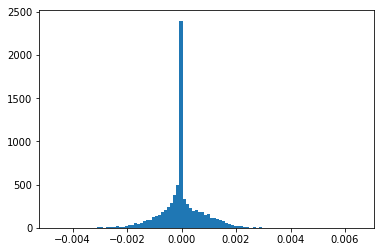

In [355]:
plt.hist(weights.flatten(), 100)
plt.show()

# Analisis de dígitos errados

In [356]:
def get_errors(model, x_test, y_test):
    predicted = model.predict(x_test)
    predicted_numbers = predicted.argmax(axis=1)
    accuracy = (predicted_numbers==y_test).sum()/predicted_numbers.shape[0]
    error_indexes = np.where((predicted_numbers==y_test)==False)[0]
    error = error_indexes.shape[0]/predicted_numbers.shape[0]
    return accuracy, error, error_indexes, predicted_numbers
accuracy, error, error_indexes, predicted_numbers = get_errors(model_single_layer, x_test, y_test)
print(accuracy, error, accuracy + error)
print(predicted_numbers.shape)

0.92 0.08 1.0
(10000,)


[5 4 3 6 7 2 3 5 8 9 3 4 6 4 7 9 2 5 8 5 2 3 8 8 5 8 2 6 4 9 7 5 5 9 8 5 3
 4 3 3 2 8 7 4 3 4 3 2 8 7 2 1 3 2 7 2 7 8 4 0 5 2 2 4 2 4 5 8 8 5 8 4 3 7
 2 3 2 8 7 1 3 4 6 2 3 9 7 6 6 3 5 7 6 3 8 5 5 8 9 4]
[6 6 3 7 4 9 8 7 7 8 5 2 0 6 9 7 7 3 8 0 7 3 5 8 5 7 8 0 4 8 9 8 8 3 3 3 5
 8 3 6 1 3 1 9 5 4 2 8 3 9 8 8 3 6 0 8 3 4 9 6 2 8 8 9 8 9 9 3 7 3 2 9 5 8
 7 5 5 9 2 6 3 4 0 3 3 7 9 5 2 5 8 9 8 3 4 3 5 2 3 6]


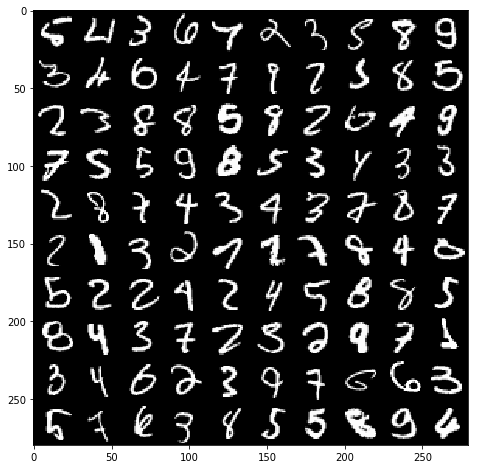

In [357]:
print(y_test[error_indexes[:100]])
print(predicted_number[error_indexes[:100]])
plot_numbers(x_test,error_indexes[:100], columns=10, figsize=(8, 8))

# Cargo pesos guardados

In [358]:
# Cargo los valores del modelo
model_single_layer.load_weights('single-layer.mnist.hdf5')
score = model_single_layer.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  0.284258356622
accuracy:  0.9213


# [Como hacer lo mismo en Tensorflow](./Tensorflow-MNIST.ipynb)

# Red de 2 capas

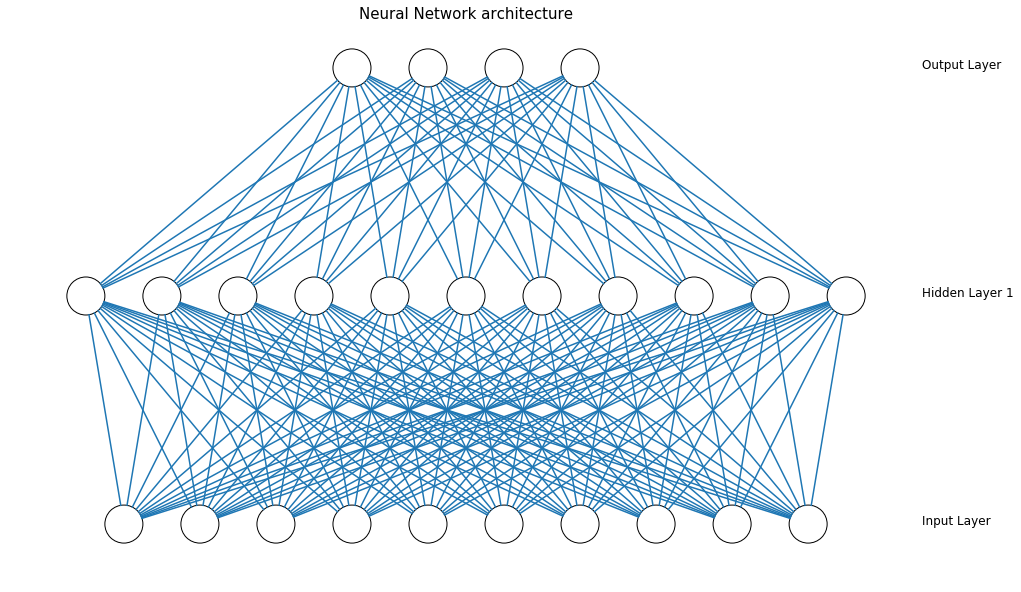

Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida


In [102]:
network = draw_nn.DrawNN( [10,11,4] )
network.draw()
print("Realmente tengo 784 neuronas en la entrada, 800 en el hidden y 10 en la salida")

Que pasa con kernel_initializar = zeros?

In [130]:
def two_layer_model(lr=0.000001, decay=0):
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='zeros', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    SGD = optimizers.SGD(lr=lr)
    model.compile(loss = 'categorical_crossentropy', optimizer=SGD, metrics=['accuracy'])
    return model
model_two_layers = two_layer_model()
model_two_layers.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_52 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle (Dense)               (None, 800)               628000    
_________________________________________________________________
Salida (Dense)               (None, 10)                8010      
Total params: 636,010
Trainable params: 636,010
Non-trainable params: 0
_________________________________________________________________


**¿de donde sale la cantidad de parametros?**

In [122]:
first_layer = 784*800+800
print(first_layer)
last_layer = 800*10 + 10
print(last_layer)
print(first_layer+last_layer)

628000
8010
636010


In [123]:
score_two_layers = model_two_layers.evaluate(x_test, y_test_categorical, verbose=0)
print("loss: ", score_two_layers[0])
print("accuracy: ", score_two_layers[1])

loss:  2.54749616547
accuracy:  0.0892


# Learning rate = 0.01

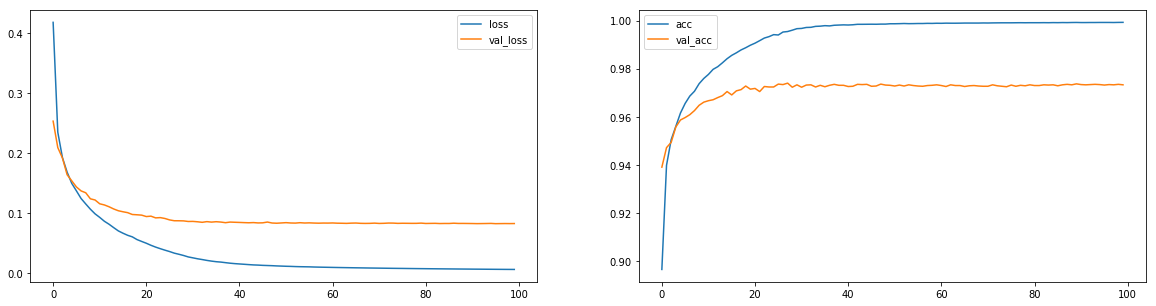

48000/48000 [==============================] - 7s - loss: 0.0064 - acc: 0.9993 - val_loss: 0.0828 - val_acc: 0.9733


In [125]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers = two_layer_model(lr=0.01) # lr=0.000001, 
model_two_layers.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

# Learning rate = 0.1

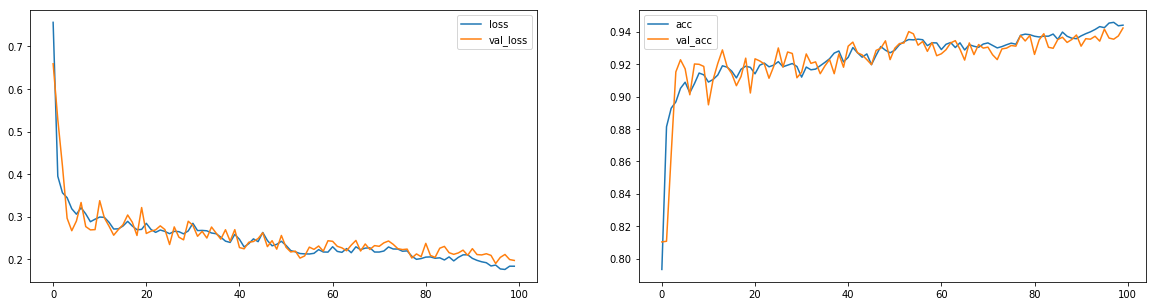

48000/48000 [==============================] - 7s - loss: 0.1834 - acc: 0.9441 - val_loss: 0.1970 - val_acc: 0.9423


In [127]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers_2 = two_layer_model(lr=0.1) # lr=0.000001, 
model_two_layers_2.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

# Learning rate = 0.1 + decay

lr = self.lr * (1. / (1. + self.decay * self.iterations))

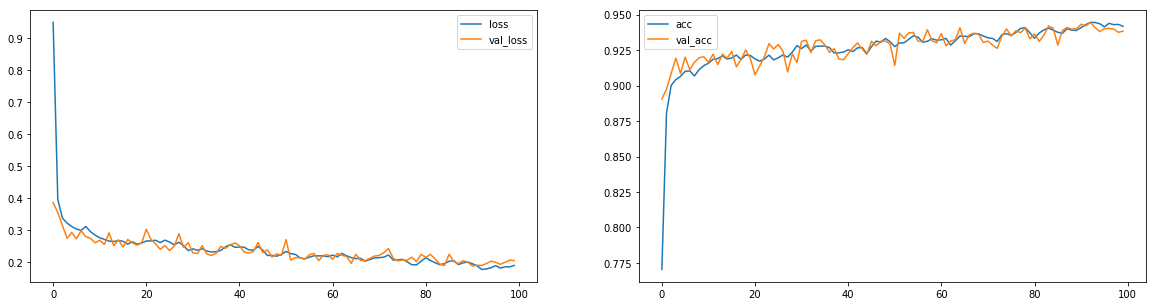

48000/48000 [==============================] - 6s - loss: 0.1897 - acc: 0.9419 - val_loss: 0.2049 - val_acc: 0.9384


In [132]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers_3 = two_layer_model(lr=0.1, decay=1e-3) # lr=0.000001, 
model_two_layers_3.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

# rmsprop

In [139]:
def two_layer_model_rms():
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='sigmoid', kernel_initializer='normal', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

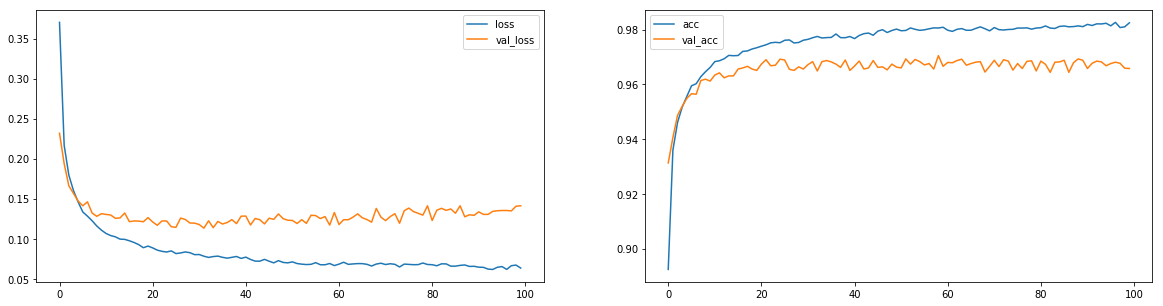

48000/48000 [==============================] - 10s - loss: 0.0635 - acc: 0.9825 - val_loss: 0.1413 - val_acc: 0.9658


In [140]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers_rms = two_layer_model_rms() # lr=0.000001, 
model_two_layers_rms.fit(x_train, 
          y_train_categorical ,
          epochs=100, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

# rmsprop + relus

In [141]:
def two_layer_model_rms_relu():
    output_size = 10
    model = Sequential()
    model.add(Flatten(input_shape=x_train.shape[1:]))
    model.add(Dense(800, activation='relu', kernel_initializer='normal', name='middle'))
    model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='Salida'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

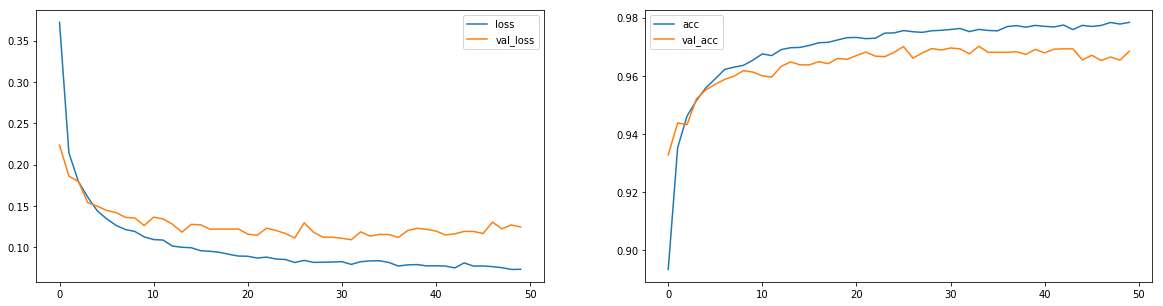

48000/48000 [==============================] - 10s - loss: 0.0732 - acc: 0.9784 - val_loss: 0.1244 - val_acc: 0.9685


In [142]:
plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_val, y_val_categorical=y_val_categorical)
model_two_layers_rms_relu = two_layer_model_rms() # lr=0.000001, 
model_two_layers_rms_relu.fit(x_train, 
          y_train_categorical ,
          epochs=50, batch_size=100, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

# Red de 5 capas - relus

In [164]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model = Sequential()
model.add(Flatten(input_shape=x_train.shape[1:]))
model.add(Dense(200, activation='relu', kernel_initializer='normal', name='middle1'))
model.add(Dense(100, activation='relu', kernel_initializer='normal', name='middle2'))
model.add(Dense(60, activation='relu', kernel_initializer='normal', name='middle3'))
model.add(Dense(30, activation='relu', kernel_initializer='normal', name='middle4'))
model.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_68 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [165]:
adam = optimizers.Adam(lr=0.001, decay=0.0) #decay=1e-4
model.compile(loss = 'categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

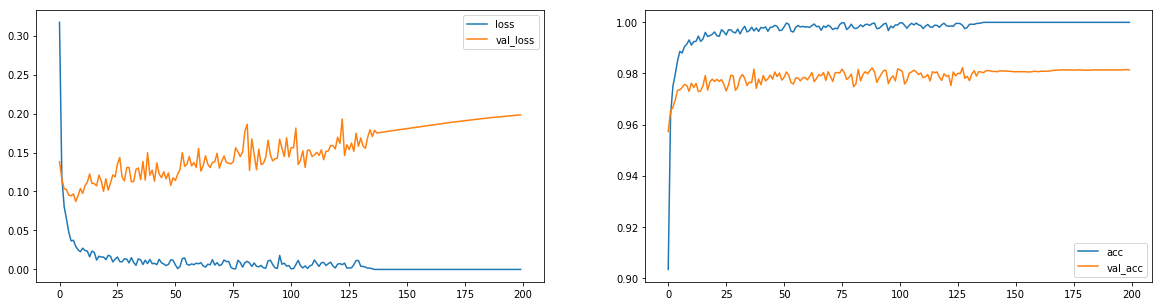

48000/48000 [==============================] - 3s - loss: 1.1977e-07 - acc: 1.0000 - val_loss: 0.1983 - val_acc: 0.9814


In [166]:
model.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=200, 
          #verbose=1, 
          validation_data=(x_test, y_test_categorical), 
          callbacks=[plot_losses],
         )

In [264]:
accuracy, error, error_indexes, predicted_numbers = get_errors(model, x_test, y_test)
print(accuracy, error, accuracy + error)
print(predicted_numbers.shape)
(y_test[error_indexes[:20]]==predicted_numbers[error_indexes[:20]]).sum()

0.9814 0.0186 1.0
(10000,)


0

[4 2 9 4 2 5 6 3 8 7]
[8 1 7 5 7 9 2 3 5 8]

[9 9 8 2 7 3 0 5 0 9]
[2 8 3 8 9 4 7 8 4 9]


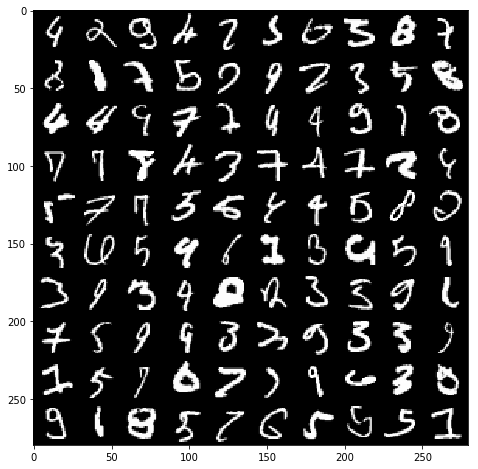

In [261]:
print(y_test[error_indexes[:10]])
print(y_test[error_indexes[10:20]])
print()
print(predicted_numbers[error_indexes[:10]])
print(predicted_numbers[error_indexes[10:20]])
plot_numbers(x_test,error_indexes[:100], columns=10, figsize=(8, 8))

# Sigmoid

In [174]:
output_size = 10
initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=None)
model_five_sigmoid = Sequential()
model_five_sigmoid.add(Flatten(input_shape=x_train.shape[1:]))
model_five_sigmoid.add(Dense(200, activation='sigmoid', kernel_initializer='normal', name='middle1'))
model_five_sigmoid.add(Dense(100, activation='sigmoid', kernel_initializer='normal', name='middle2'))
model_five_sigmoid.add(Dense(60, activation='sigmoid', kernel_initializer='normal', name='middle3'))
model_five_sigmoid.add(Dense(30, activation='sigmoid', kernel_initializer='normal', name='middle4'))
model_five_sigmoid.add(Dense(output_size, activation='softmax', kernel_initializer='normal', name='salida'))
model_five_sigmoid.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_71 (Flatten)         (None, 784)               0         
_________________________________________________________________
middle1 (Dense)              (None, 200)               157000    
_________________________________________________________________
middle2 (Dense)              (None, 100)               20100     
_________________________________________________________________
middle3 (Dense)              (None, 60)                6060      
_________________________________________________________________
middle4 (Dense)              (None, 30)                1830      
_________________________________________________________________
salida (Dense)               (None, 10)                310       
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
_________________________________________________________________


In [175]:
model_five_sigmoid.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

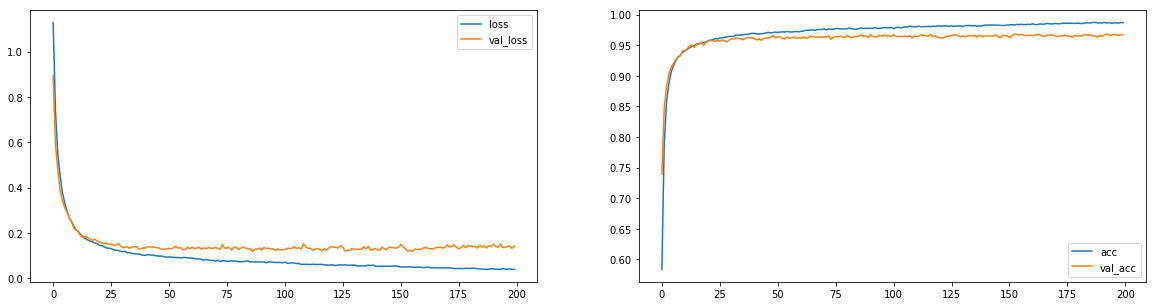

48000/48000 [==============================] - 3s - loss: 0.0401 - acc: 0.9870 - val_loss: 0.1418 - val_acc: 0.9671


In [177]:
model_five_sigmoid.fit(x_train, 
          y_train_categorical ,
          epochs=200, batch_size=100, 
          #verbose=1, 
          validation_data=(x_val, y_val_categorical), 
          callbacks=[plot_losses],
         )

In [266]:
accuracy, error, error_indexes, predicted_numbers = get_errors(model_five_sigmoid, x_test, y_test)
print(accuracy, error, accuracy + error)
print(predicted_numbers.shape)
(y_test[error_indexes[:20]]==predicted_numbers[error_indexes[:20]]).sum()

0.9634 0.0366 1.0
(10000,)


0

[5 4 9 8 8 2 5 3 5 6]
[4 9 9 2 8 2 8 2 5 5]

[8 9 8 5 1 7 3 7 3 0]
[9 3 3 3 2 3 2 1 3 3]


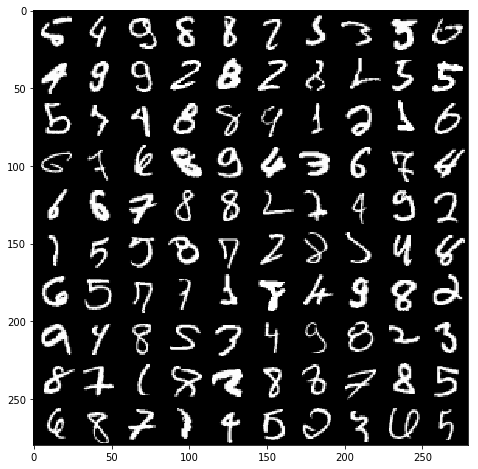

In [267]:
print(y_test[error_indexes[:10]])
print(y_test[error_indexes[10:20]])
print()
print(predicted_numbers[error_indexes[:10]])
print(predicted_numbers[error_indexes[10:20]])
plot_numbers(x_test,error_indexes[:100], columns=10, figsize=(8, 8))

# Limitaciones de MLP para clasificación de imágenes:
- Cantidad muy grande de parametros!
- Se pierde morfología con el flatten. 